 # HU Extension       Code for Final Project       CSCI-E89 Deep learning

## Name : Sheetal Darekar


### 1. Problem Statement:
Autonomous driving field is very popular these days. The goal of this project is to explore how Deep Learning is used in various self driving car algorithms. The objective here is to train a deep learning model that can make predictions for the steering angle based on input camera images and the last known state of the vehicle. 

![SELF DRIVING SIMULATOR](SDC.jpeg)

### 1.1 Requirements

#### Hardware
I developed/ executed Data Cleaning and testing part of the code on a HP Z-book laptop running Windows 10 Home edition (64-bit) on an Intel® Core™ i7-7820 CPU processor. The laptop is equipped with 32 gigabytes of RAM and no dedicated graphics processing unit.  


I trained the model on AWS EC2 p3.8Xlarge instance.  

#### Software and Important Packages
[AirSim Simulator](https://github.com/Microsoft/AirSim)
python==3.6.3  

h5py==2.8.0 

Keras==2.1.3 (had to downgrade for AirSim to work) 

msgpack-python==0.5.6 

msgpack-rpc-python==0.4.1 

opencv-python==3.4.0.12 

tensorflow-gpu==1.10.0 

tornado==4.5.3 

### 2. Data Gathering and Understanding:

The dataset was obtained from https://aka.ms/AirSimTutorialDataset. This link has a good collection of data from the AirSim simulation environment. With simulators like [AirSim](https://github.com/Microsoft/AirSim), it is possible to collect a large amount of data to train the models without having to use an actual car. The dataset for this is quite large - about more than 3.5 GB. The simulator includes both training and autonomous modes, and two tracks on which the car can be driven - train track which is the track from which training data is collected and test track which is later used in the test section. 

In training mode, the simulator produces three images per frame while recording corresponding images. The simulator also produces a `tsv` file which includes file paths for each of these images, along with the associated steering angle, throttle, brake, and speed for each frame. Images produced by the simulator in training mode are 148X256.

### 3. Data Cleaning and Exploration:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

The data is organized in 9 folders as below classified as 'normal' and 'swerve'. These names refer to two different driving strategies. We will explore more in below sections.

In [2]:
RAW_DATA_DIR = 'data_raw/'
#There are 6 folders under raw data
DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']
FIGURE_SIZE = (10,10)
COOKED_DATA_DIR = 'data_cooked/'

The dataset as mentioned earlier has two parts - the images and the .tsv file. Let's check both one by one.

In [3]:
tsv_path = os.path.join(RAW_DATA_DIR, 'normal_1/airsim_rec.txt')
tsv = pd.read_csv(tsv_path, sep='\t')
tsv.head()

,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName
0,93683464,0,0.0,0.000000,0.0,N,img_0.png
1,93689595,0,0.0,0.000000,0.0,N,img_1.png
2,93689624,0,0.0,-0.035522,0.0,N,img_2.png
3,93689624,0,0.0,-0.035522,0.0,N,img_3.png
4,93689624,0,0.0,-0.035522,0.0,N,img_4.png


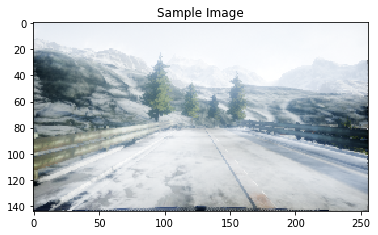

In [4]:
image_path = os.path.join(RAW_DATA_DIR, 'normal_1/images/img_100.png')
image = Image.open(image_path)
plt.title('Sample Image')
plt.imshow(image)
plt.show()

We do not need the whole image to determine at what angle to steer the car. We can process the image to show only a certain area that is enough to predict angle of steer. This pre-processed image just focuses on the Region of Interest of the image as shown in red below. The below method accepts an image input, float angle, float pred_angle and integer frame co-ordinates, and it returns an annotated image ready for display. 

The ROI size after adding the above method is 64 X 255. I manually optimized this size to get the desired region. We use this approach later to focus our training only to this region to avoid training with too much useless data. This also reduces the size of the data since only part of the image is used. More discussion below.

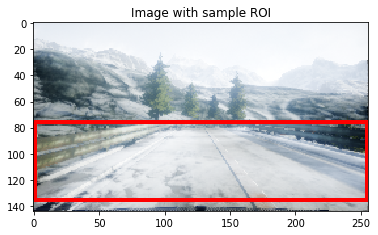

In [5]:
image_roi = image.copy()
fillcolor=(255,0,0)
draw = ImageDraw.Draw(image_roi)
points = [(1,76), (1,135), (255,135), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw
plt.title('Image with sample ROI')
plt.imshow(image_roi)
plt.show()

As discussed we had 6 .tsv files in the dataset; below code combines all into 1 file.

In [6]:
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]

dataframes = []
for folder in full_path_raw_folders:
    current_dataframe = pd.read_csv(os.path.join(folder, 'airsim_rec.txt'), sep='\t')
    current_dataframe['Folder'] = folder
    dataframes.append(current_dataframe)    
dataset = pd.concat(dataframes, axis=0)
print('Number of data points: {0}'.format(dataset.shape[0]))


Number of data points: 46738


The two different driving strategies are plotted below to see the difference.

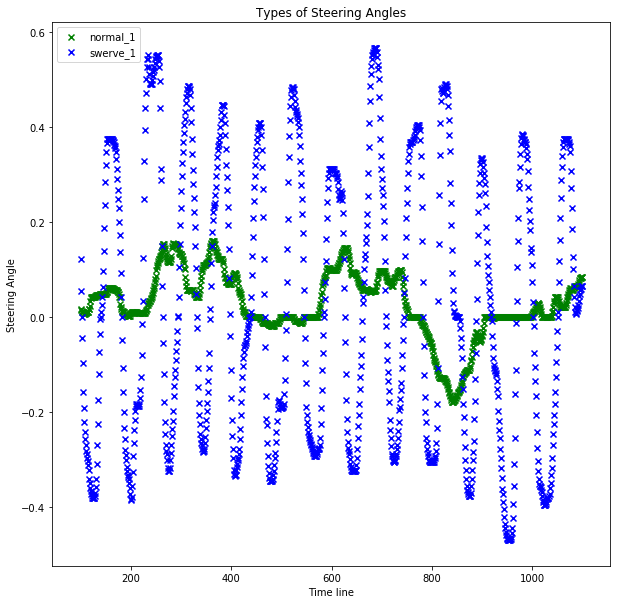

In [7]:
min_index = 100
max_index = 1100
steering_angles_normal_1 = dataset[dataset['Folder'].apply(lambda v: 'normal_1' in v)]['Steering'][min_index:max_index]
steering_angles_swerve_1 = dataset[dataset['Folder'].apply(lambda v: 'swerve_1' in v)]['Steering'][min_index:max_index]

plot_index = [i for i in range(min_index, max_index, 1)]

fig = plt.figure(figsize=FIGURE_SIZE)
ax1 = fig.add_subplot(111)

ax1.scatter(plot_index, steering_angles_normal_1, c='g', marker='x', label='normal_1')
ax1.scatter(plot_index, steering_angles_swerve_1, c='b', marker='x', label='swerve_1')
plt.legend(loc='upper left');
plt.title('Types of Steering Angles')
plt.xlabel('Time line')
plt.ylabel('Steering Angle')
plt.show()

From above graph we can see that the swerving driving strategy (green) has the car almost oscillating side to side across the road, while the normal (blue) has the car mostly driven in the center of the road.

In [8]:
dataset['Is Swerve'] = dataset.apply(lambda r: 'swerve' in r['Folder'], axis=1)
grouped = dataset.groupby(by=['Is Swerve']).size().reset_index()
grouped.columns = ['Is Swerve', 'Count']

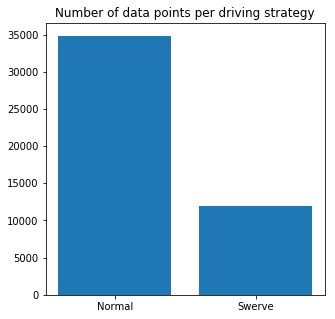

In [9]:
pie_labels = ['Normal', 'Swerve']
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x =pie_labels,height = grouped['Count'], data = grouped)
plt.title('Number of data points per driving strategy')
plt.show()

C:\Users\dareksh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\dareksh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


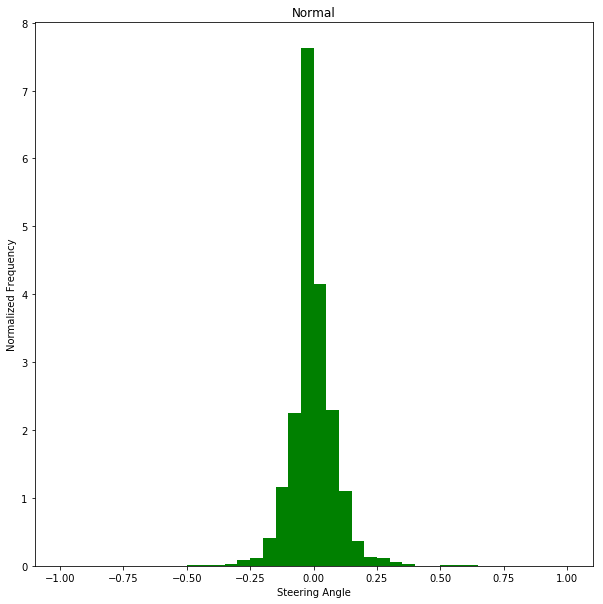

In [10]:
bins = np.arange(-1, 1.05, 0.05)
normal = dataset[dataset['Is Swerve'] == False]['Steering']
plt.figure(figsize=FIGURE_SIZE)
n, b, p = plt.hist(normal.as_matrix(), bins, normed=1, facecolor='green')
plt.xlabel('Steering Angle')
plt.ylabel('Normalized Frequency')
plt.title("Normal")
plt.show()

C:\Users\dareksh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dareksh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


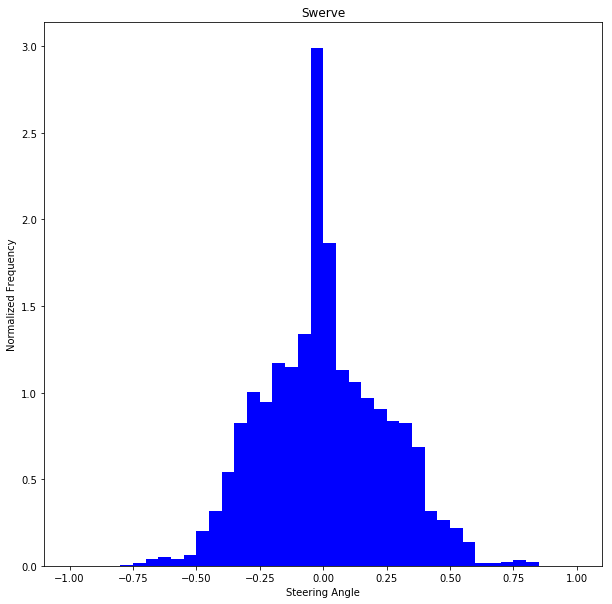

In [11]:
swerve= dataset[dataset['Is Swerve'] == True]['Steering']
plt.figure(figsize=FIGURE_SIZE)
n, b, p = plt.hist(swerve.as_matrix(), bins, normed=1, facecolor='blue')
plt.xlabel('Steering Angle')
plt.ylabel('Normalized Frequency')
plt.title("Swerve")
plt.show()

From above histograms we can see the angle for normal is mostly centered at zero, whereas angles for swerve are widely distributed.

AirSim has their API to make all the above changes called 'Cooking'.

The API combines the raw data into compressed data files suitable for training. Here, we will use .h5 files, as this format is ideal for supporting large datasets without reading everything into memory all at once. It also works seamlessly with Keras.

The code for cooking the dataset is straightforward, but long. When it terminates, the final dataset will have 4 parts:

* **image**: a numpy array containing the image data
* **previous_state**: a numpy array containing the last known state of the car. This is a (steering, throttle, brake, speed) tuple
* **label**: a numpy array containing the steering angles that we wish to predict (normalized on the range -1..1)
* **metadata**: a numpy array containing metadata about the files (which folder they came from, etc)

The processing may take some time. We will also combine all the datasets into one and then split it into train/test/validation datasets. The train - test - eval split ratios are 0.7: 0.2: 0.1

In [ ]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

### 4. Training the model:

In [20]:
#Adding all the useful packages
import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image
from keras_tqdm import TQDMNotebookCallback

Let's read in the datasets from above.

In [21]:
# Cooked data from data cleaning
COOKED_DATA_DIR = 'data_cooked/'
# Folder to save output
MODEL_OUTPUT_DIR = 'model'
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')
num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]
batch_size=32

Below function helps to plot the steering angle. For now the red line shows original steering angle. But we can use the same function to see how the trained model predicts the angle against the original angle of steering. I have a diagram to explain this function in detail. If time permits I will add the diagram.

When working with datasets that have a large memory footprint (large quantities of image data, in particular) Keras python generators are a convenient way to load the dataset one batch at a time rather than loading it all at once. 

In [22]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], 
     batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'],
     batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])    


Actual Steering Angle = [0.01389967]


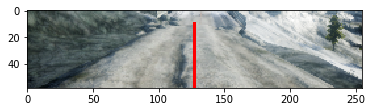

Actual Steering Angle = [-0.097398]


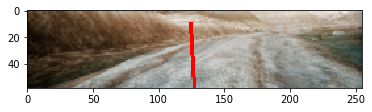

Actual Steering Angle = [0.025808]


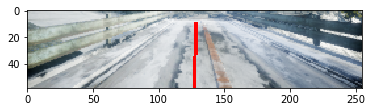

In [23]:
#code ref added in ref section
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - 
                                                                                 (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

### 4.1 Without Data Augmentation:

#### 4.1.1 Model Architecture: 
A standard combination of convolutional / max pooling layers to process the images. AirSim discussion also suggests we should inject the vehicle's last known state into the dense layer as an additional features which I did. The layer sizes and optimization parameters were determined manually as discussed in the cleaning section, but I use that only in section 4.2. For section 4.1 I tried original data.
Since the image is the whole image in this case, with the additional features. The image is of the size 320 X 160. Plus we add the additional features of current state of the car. 
We add 3 dropout layers to make sure the model learns well for all the situations. A Relu function is used as a activation function and an Adam optomizer is used as the optimizer


In [26]:
[sample_batch_train_data, sample_batch_test_data] = next(train_dataset)
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse',metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### 4.1.2 Model Summary:

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

That's a lot of parameters! 
One of the nice features of Keras is the ability to declare callbacks. Few Callbacks applied are below (referred from AirSim Cookbook):

* **ReduceLrOnPlateau** - If the model is near a minimum and the learning rate is too high, then the model will circle around that minimum without ever reaching it. This callback will allow us to reduce the learning rate when the validation loss stops improving, allowing us to reach the optimal point.
* **CsvLogger** - This lets us log the output of the model after each epoch, which will allow us to track the progress without needing to use the console.
* **ModelCheckpoint** - Generally, we will want to use the model that has the lowest loss on the validation set. This callback will save the model each time the validation loss improves.
* **EarlyStopping** - We will want to stop training when the validation loss stops improving. Otherwise, we risk overfitting. This monitor will detect when the validation loss stops improving, and will stop the training process when that occurs.

In [28]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', 
                                                                                             '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

### Not shwing output as to avoid long PDF. 

In [32]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Unfortuantely above model does not converge. I left the above code to run for 2 hours on AWS EC2 p3.8xlarge instance. It did not coverge, hence decided to go with the suggestions of Data Augmentation.

### 4.2 With Data Augmentation:
Since images are too expensive to load the entire dataset into memory, let's advantage of Keras DataGenerators which works like a normal interator in python which helps in increasing the throughput. 

We use following Data Augmentation techniques:
1. Only a small portion of the image is of interest - Focus on ROI as discussed in Data Cleaning part.
2. AirSim also suggests to augment the data by randomly flip some images and labels around the Y axis so the model has new data to learn from.
3. Randomly add or remove brightness from the images so the model can learn that changes in lighting should be ignored.
4. The dataset has a high proportion of images where the steering angle is zero or close to zero. To balance the data we randomly drop a percentage of data points where the steering angle is zero.
5. We need examples from the swerving strategy in our dataset so the model learns how to turn sharply 

While Keras does have some standard built-in transforms for images, however AirSim provides with a package called Generator.py. Alhough, the code in that file is straightforward to implement ourselves, I decided to focus on modelling and optimizing than cleaning at this point as it too long to be done in short 3 weeks of span.

Here, we will initialize the generator with the following parameters:
* **Zero_Drop_Percentage: 0.9** - That is, we will randomly drop 90% of the data points with label = 0
* **Brighten_Range: 0.4** - That is, the brighness of each image will be modified by up to 40%. To compute "brightness", we transform the image from RGB to HSV space, scale the 'V' coordinate up or down, and transform back to RGB space.
* **ROI: [76,135,0,255]** - This is the x1, x2, y1, y2 rectangle that represents the area of interest for the images.

In [33]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,135,0,255])    

#### 4.2.1 Model Architecture: 
A standard combination of convolutional / max pooling layers to process the images. AirSim also suggests we should inject the vehicle's last known state into the dense layer as an additional features. The layer sizes and optimization parameters were determined manually as discussed in the cleaning section.
Since the image is the whole image in this case, with the additional features. The image is of the size 148 X 255. Plus we add the additional features of current state of the car. 
We add 3 dropout layers to make sure the model learns well for all the situations. A Relu function is used as a activation function and an Adam optomizer is used as the optimizer

In [34]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse',metrics=['accuracy'])

#### Model Summary:

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

That's a lot of parameters! Fortunately, we have our data augmentation strategies, so the network has a chance of converging. Try adding / removing layers or changing their widths to see what effect it has on the number of trainable parameters in the network.

One of the nice features of Keras is the ability to declare callbacks. Few Callbacks applied are below (referred from AirSim Cookbook):

* **ReduceLrOnPlateau** - If the model is near a minimum and the learning rate is too high, then the model will circle around that minimum without ever reaching it. This callback will allow us to reduce the learning rate when the validation loss stops improving, allowing us to reach the optimal point.
* **CsvLogger** - This lets us log the output of the model after each epoch, which will allow us to track the progress without needing to use the console.
* **ModelCheckpoint** - Generally, we will want to use the model that has the lowest loss on the validation set. This callback will save the model each time the validation loss improves.
* **EarlyStopping** - We will want to stop training when the validation loss stops improving. Otherwise, we risk overfitting. This monitor will detect when the validation loss stops improving, and will stop the training process when that occurs.

One useful tool built into the Keras framework is the ability to use callbacks to perform tasks along the way through the model training process. I chose to implement checkpoints to save the model weights at the end of each epoch. In a more typical application of neural networks, it might make more sense to simply end the learning process once the loss stops improving from one epoch to the next. However, in this application the loss was not an entirely reliable indicator of model performance, so saving model weights at the end of each epoch is was easy.

In [36]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

The model was trained in AWS. The model took about ~45 min to train on AWS EC2 p3.8Xlarge instance. 
I applied early stop which reduced this time to 25 minutes.

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/500
Epoch 00001: val_loss improved from inf to 0.02174, saving model to model/models/model_model.01-0.0217410.h5
 - 63s - loss: 0.0231 - acc: 0.0063 - val_loss: 0.0217 - val_acc: 0.0065


Epoch 2/500
Epoch 00002: val_loss improved from 0.02174 to 0.01124, saving model to model/models/model_model.02-0.0112363.h5
 - 37s - loss: 0.0193 - acc: 0.0067 - val_loss: 0.0112 - val_acc: 0.0069


Epoch 3/500
Epoch 00003: val_loss improved from 0.01124 to 0.00455, saving model to model/models/model_model.03-0.0045516.h5
 - 37s - loss: 0.0098 - acc: 0.0070 - val_loss: 0.0046 - val_acc: 0.0065


Epoch 4/500
Epoch 00004: val_loss improved from 0.00455 to 0.00169, saving model to model/models/model_model.04-0.0016859.h5
 - 38s - loss: 0.0051 - acc: 0.0071 - val_loss: 0.0017 - val_acc: 0.0075


Epoch 5/500
Epoch 00005: val_loss improved from 0.00169 to 0.00131, saving model to model/models/model_model.05-0.0013089.h5
 - 37s - loss: 0.0037 - acc: 0.0064 - val_loss: 0.0013 - val_acc: 0.0066


Epoch 6/500
Epoch 00006: val_loss improved from 0.00131 to 0.00079, saving model to model/models/model_model.06-0.0007866.h5
 - 38s - loss: 0.0029 - acc: 0.0065 - val_loss: 7.8659e-04 - val_acc: 0.0060


Epoch 7/500
Epoch 00007: val_loss improved from 0.00079 to 0.00047, saving model to model/models/model_model.07-0.0004729.h5
 - 38s - loss: 0.0025 - acc: 0.0065 - val_loss: 4.7286e-04 - val_acc: 0.0072


Epoch 8/500
Epoch 00008: val_loss improved from 0.00047 to 0.00042, saving model to model/models/model_model.08-0.0004225.h5
 - 37s - loss: 0.0022 - acc: 0.0067 - val_loss: 4.2247e-04 - val_acc: 0.0062


Epoch 9/500
Epoch 00009: val_loss improved from 0.00042 to 0.00034, saving model to model/models/model_model.09-0.0003412.h5
 - 37s - loss: 0.0021 - acc: 0.0073 - val_loss: 3.4121e-04 - val_acc: 0.0063


Epoch 10/500
Epoch 00010: val_loss did not improve
 - 37s - loss: 0.0021 - acc: 0.0066 - val_loss: 4.9691e-04 - val_acc: 0.0074


Epoch 11/500
Epoch 00011: val_loss did not improve
 - 38s - loss: 0.0021 - acc: 0.0074 - val_loss: 4.2327e-04 - val_acc: 0.0066


Epoch 12/500
Epoch 00012: val_loss improved from 0.00034 to 0.00033, saving model to model/models/model_model.12-0.0003267.h5
 - 37s - loss: 0.0021 - acc: 0.0077 - val_loss: 3.2671e-04 - val_acc: 0.0050


Epoch 13/500
Epoch 00013: val_loss did not improve
 - 38s - loss: 0.0020 - acc: 0.0059 - val_loss: 4.0574e-04 - val_acc: 0.0069


Epoch 14/500
Epoch 00014: val_loss did not improve
 - 37s - loss: 0.0020 - acc: 0.0066 - val_loss: 4.3229e-04 - val_acc: 0.0054


Epoch 15/500
Epoch 00015: val_loss improved from 0.00033 to 0.00025, saving model to model/models/model_model.15-0.0002490.h5
 - 38s - loss: 0.0020 - acc: 0.0074 - val_loss: 2.4903e-04 - val_acc: 0.0087


Epoch 16/500
Epoch 00016: val_loss did not improve
 - 37s - loss: 0.0020 - acc: 0.0065 - val_loss: 2.5839e-04 - val_acc: 0.0072


Epoch 17/500
Epoch 00017: val_loss did not improve
 - 37s - loss: 0.0020 - acc: 0.0069 - val_loss: 2.5390e-04 - val_acc: 0.0074


Epoch 18/500
Epoch 00018: val_loss did not improve
 - 38s - loss: 0.0020 - acc: 0.0068 - val_loss: 2.8678e-04 - val_acc: 0.0054


Epoch 19/500
Epoch 00019: val_loss did not improve
 - 37s - loss: 0.0020 - acc: 0.0063 - val_loss: 4.5500e-04 - val_acc: 0.0065


Epoch 20/500
Epoch 00020: val_loss did not improve
 - 38s - loss: 0.0020 - acc: 0.0077 - val_loss: 3.1844e-04 - val_acc: 0.0069


Epoch 21/500
Epoch 00021: val_loss did not improve
 - 37s - loss: 0.0019 - acc: 0.0071 - val_loss: 3.1298e-04 - val_acc: 0.0066


Epoch 22/500
Epoch 00022: val_loss did not improve
 - 37s - loss: 0.0020 - acc: 0.0072 - val_loss: 3.9058e-04 - val_acc: 0.0047


Epoch 23/500
Epoch 00023: val_loss did not improve
 - 38s - loss: 0.0019 - acc: 0.0060 - val_loss: 3.0904e-04 - val_acc: 0.0058


Epoch 24/500
Epoch 00024: val_loss did not improve
 - 37s - loss: 0.0019 - acc: 0.0071 - val_loss: 3.1586e-04 - val_acc: 0.0064


Epoch 25/500
Epoch 00025: val_loss did not improve
 - 37s - loss: 0.0019 - acc: 0.0071 - val_loss: 2.8516e-04 - val_acc: 0.0069
Epoch 00025: early stopping


#### Training and Validation Loss against number of epochs

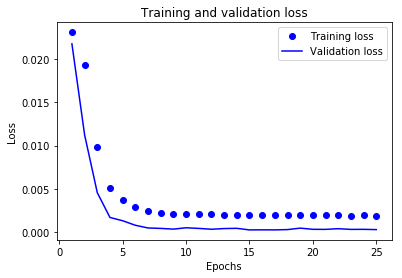

In [39]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Training and Validation Acc against number of epochs

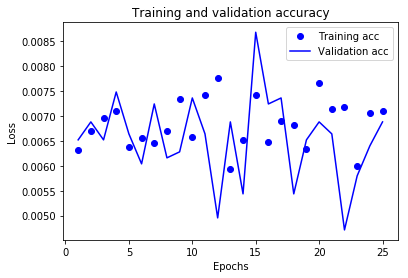

In [40]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Let's plot our predictions against the original steering angles and compare the labels and the predictions. These should be very close in value if our model has learned properly.

Actual Steering Angle = [-0.035522]
Predicted Steering Angle = [-0.0003692]
L1 Error: [ 0.0351528]


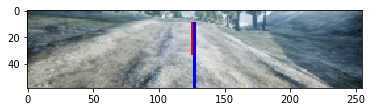

Actual Steering Angle = [ 0.12993667]
Predicted Steering Angle = [-0.0003692]
L1 Error: [ 0.13030587]


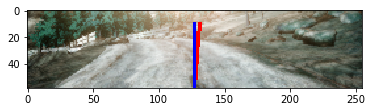

Actual Steering Angle = [-0.09872733]
Predicted Steering Angle = [-0.0003692]
L1 Error: [ 0.09835813]


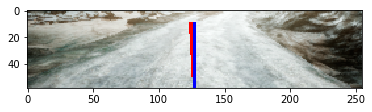

In [9]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(600, 60, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

### 4.3 Observations:
From above we can see that the predictions matches pretty well with the label. Number of other ways to improve the model accuracy is discussed in the futurework section below. Although this code is just a beginning in the self driving car world, it gives a great insight into how we can use Deep Learning to create models in the Autonomous Vehicles field. 

### 5. Simulation in AirSim to see how our model performs in reality:

Most of the code below is taken from AirSim website. **Make sure you have the AirSim running before running below code for it to work.** For me running this part was the trickiest. The set-up file for AirSim was 17GB in .7z format which took the longest time to download. This part of the code also uses the AirSim Client which needs the module called msgpack-rpc-python, which some how I was not able to install on anaconda. It installed perfectly fine using pip but did not work with conda. I also played almost for 3-4 days trying to run it on AWS EC2 instance of p3.8X large. But since it needs AirSim I had to move the 17GB set up file to AWS, then try number of ways to unzip .7z file format. AWS let's you unzip .zip file formats but doesn't let you unzip .7z file formats. After moving unzipped file format to AWS, it did not let .exe file to run it, which threw my whole plan off. And I wasted about 8-9 days of my time. My final option was to make another file called .py with just below code and run it outside of jupyter notebook with command prompt. This worked for other types of terrains but not the particular terrain for which I had trained the models with. However, just watching it run on otherterains gave me a good idea of how everything works.

In [ ]:
from keras.models import load_model
import sys
import numpy as np
import glob
import os

if ('../../PythonClient/' not in sys.path):
    sys.path.insert(0, '../../PythonClient/')
from AirSimClient import *

# << Set this to the path of the model >>
# If None, then the model with the lowest validation loss from training will be used
MODEL_PATH = None

if (MODEL_PATH == None):
    models = glob.glob('model/models/*.h5') 
    best_model = max(models, key=os.path.getctime)
    MODEL_PATH = best_model
    
print('Using model {0} for testing.'.format(MODEL_PATH))
model = load_model(MODEL_PATH)

client = CarClient()
client.confirmConnection()
client.enableApiControl(True)
car_controls = CarControls()
print('Connection established!')

The initial state of the car is set below, as well as some buffers used to store the output from the model

In [ ]:
car_controls.steering = 0
car_controls.throttle = 0
car_controls.brake = 0

image_buf = np.zeros((1, 59, 255, 3))
state_buf = np.zeros((1,4))

We'll define a helper function to read a RGB image from AirSim and prepare it for consumption by the model

In [ ]:
def get_image():
    image_response = client.simGetImages([ImageRequest(0, AirSimImageType.Scene, False, False)])[0]
    image1d = np.fromstring(image_response.image_data_uint8, dtype=np.uint8)
    image_rgba = image1d.reshape(image_response.height, image_response.width, 4)
    
    return image_rgba[76:135,0:255,0:3].astype(float)

Finally, a control block to run the car. Because our model doesn't predict speed, we will attempt to keep the car running at a constant 5 m/s. Running the block below will cause the model to drive the car!

In [ ]:
while (True):
    car_state = client.getCarState()
    
    if (car_state.speed < 5):
        car_controls.throttle = 1.0
    else:
        car_controls.throttle = 0.0
    
    image_buf[0] = get_image()
    state_buf[0] = np.array([car_controls.steering, car_controls.throttle, car_controls.brake, car_state.speed])
    model_output = model.predict([image_buf, state_buf])
    car_controls.steering = round(0.5 * float(model_output[0][0]), 2)
    
    print('Sending steering = {0}, throttle = {1}'.format(car_controls.steering, car_controls.throttle))
    
    client.setCarControls(car_controls)

#### Other Failed Attempts:
Some other strategies implemented to combat overfitting and otherwise attempt to get the car to drive better:

- Removing dropout layers and adding L2 regularization (lambda of 0.001) to all model layers - convolutional and fully-connected
- Removing tanh activations on fully-connected layers and adding ELU activations to all model layers - convolutional and fully-connected
- Adjust learning rate of Adam optimizer to 0.0001 (rather than the default of 0.001)

Although these techniques were failed attempts I strongly believe with more time and iteration I can improve the model.

### 6. Conclusion and Futurework: 
This project was very daunting at the begining as I was completely new to trying out Deep Learning in Autonomous Vehicle field. I realised it is hard and reiterated process but proved it really is all about the data. Making changes to the model rarely seemed to have quite the impact that a change to the fundamental makeup of the training data typically had. 

I wish I had more time to spend the data and model to perform optimally, but to manage my time effectively I chose to conclude my efforts as soon as the model performed satisfactorily and focussed on getting the simulator running which was a mistake. I fully plan to revisit this project when time permits and especially try simulation with correct environment.

One way that I would like to improve my implementation is try other data augmentation techniques such as adding Gaussian Blur and Jitters to create more samples for training. I also would like to improve the implementation related to the distribution flattening scheme, where a very large chunk of data is thrown out, never to be seen again. I know I did this to balance the dataset out (taking a leaf out of my machine learning class) I find this bothersome for this project, and I feel that wasting data like this (even if it is mostly zero/near-zero steering angles) is a missed opportunity to train a model that can better generalize. In the future, I would like to pass the full dataset (including image_paths and angles), throwing out a different portion of the data each epoch or batch.

Most importantly I would also like to add Reinforcement Learning techniques such Deep Q Neural Network and apply to see how the model improves. I'm sure I'll see dramatical changes with this improvement. 

I enjoyed this project thoroughly and I'm very pleased with the results. Training the car to drive itself, with relatively little effort and virtually no explicit guidance, was extremely rewarding.

### 7. References:

https://microsoft.github.io/AirSim/docs/build_windows/#build-airsim-on-windows

https://github.com/microsoft/AirSim

https://github.com/Microsoft/AutonomousDrivingCookbook

https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

https://github.com/commaai/research/blob/master/train_steering_model.py 

Sallab, A.E., Abdou, M., Perot, E., and Yogamani, S.: ‘Deep reinforcement learning framework for autonomous driving’, Electronic Imaging, 2017

### 8. Youtube URLs to Presentations
2 Min: https://youtu.be/mqFhV7wtgik 

15 Min: https://youtu.be/JpCJ8FbPBJM
